In [1]:
import pynumdiff

In [2]:
# external imports
import numpy as np
import time
import math
import scipy.signal

# local imports
import pynumdiff
simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate

In [3]:
import matplotlib.pyplot as plt
from importlib import reload

In [4]:
# simulation parameters

# noise is generated using np.random, e.g. np.random.normal, np.random.uniform, np.random.poisson
# noise_type and noise_parameters should be compatible with np.random functions 
noise_type = 'normal'
noise_parameters = [0, 0.05]

# time step and time series length
dt = 0.01
timeseries_length = 4 # steps

In [5]:
# simulate data

x, x_truth, dxdt_truth, extras = simulate.linear_autonomous(dt=dt,
                                                   timeseries_length=timeseries_length,
                                                   noise_type=noise_type, 
                                                   noise_parameters=noise_parameters,
                                                           simdt=0.0001)

[[ 1.e+00  1.e-04  0.e+00]
 [ 0.e+00  1.e+00  1.e-04]
 [-1.e+02 -3.e+00  1.e-02]]


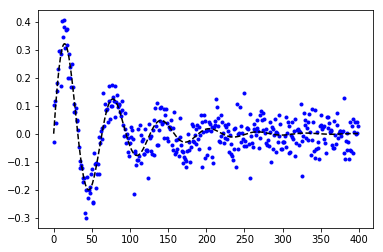

In [6]:
plt.plot(x, '.', color='blue')
plt.plot(x_truth, color='black', linestyle='--')

# Constant Acceleration Kalman Smoother

In [7]:
params, val = pynumdiff.optimize.kalman_smooth.constant_acceleration(x, dt, dxdt_truth=dxdt_truth)
#params = [0.1**2, 10]

In [8]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.constant_acceleration(x, dt, params)

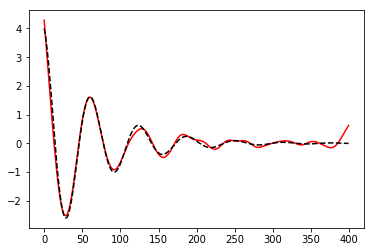

In [9]:
plt.plot(dxdt_hat, color='red')
plt.plot(dxdt_truth, color='black', linestyle='--')

### RMS error in velocity estimate

This represents the best case RMS error in the velocity, assuming that the parameters happened to be chosen optimally. 

In [10]:
print(np.sqrt(np.mean((dxdt_hat - dxdt_truth)**2)))

0.1315559037660813


# Kalman Smoother with Correct Dynamics

If we happen to the know the dynamics of the process that resulted in the time series, we can use this to signficantly improve our estimate of the derivative. 

In [11]:
params = [noise_parameters[1]**2, 1e-1]

r, q = params

#A = np.matrix([[1, dt, 0], 
#               [0, 1, dt],
#               [0, 0, 1]])
A = np.matrix([[1, dt, 0], [0, 1, dt], [-100, -5, -.05]])

B = np.matrix([[0], [0], [0]])
C = np.matrix([[1, 0, 0]])
R = np.matrix([[r]])
Q = np.matrix([[1e-16, 0, 0], 
               [0, 1e-16, 0],
               [0,     0, q]])

x0 = np.matrix([[0], [4], [-13]])
P0 = np.matrix(100*np.eye(A.shape[0]))

In [12]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.known_dynamics(x, dt, [x0, P0, A, B, C, R, Q], 
                                                         options={'forwardbackward': True})

In [13]:
# first point is wrong
x_hat[0] = x0[0,0]
dxdt_hat[0] = x0[1,0]

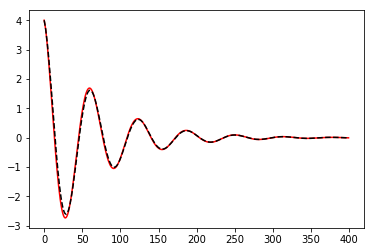

In [14]:
plt.plot(dxdt_hat, color='red')
plt.plot(dxdt_truth, color='black', linestyle='--')

### RMS error in velocity estimate

This represents the best case RMS error in the velocity, assuming that the parameters happened to be chosen optimally. 

In [15]:
print(np.sqrt(np.mean((dxdt_hat - dxdt_truth)**2)))

0.07088212659472926


### Questions:
* First point is wrong? Why???

# What if the model is not known?

Observability discussion: while it is in principle possible to simultaneously estimate the parameters of A, and the derivative, it is not easy. 

# Data driven solution for A, Integral form

Use convex optimization to find the continuous form of A, and convert that to a discrete form.

In [16]:
N, gamma = [3, 0.001]
mean = np.mean(x)
x = x - mean

# Generate the matrix of integrals of x
X = [x]
for n in range(1,N):
    X.append(pynumdiff.utils.utility.integrate_dxdt_hat(X[-1], dt) )
X = np.matrix(np.vstack(X[::-1]))
integral_Xdot = X
integral_X = pynumdiff.linear_model.__integrate_dxdt_hat_matrix__(X, dt)

# Solve for A and the integration constants
A, C =  pynumdiff.linear_model.__solve_for_A_and_C_given_X_and_Xdot__(integral_X, integral_Xdot, N, dt, gamma)
print('Continuous estimate of A')
print(A)

Continuous estimate of A
[[-1.57191081e-15  9.99999998e-01 -1.43052218e-16]
 [ 3.02886487e-16  3.48440441e-16  9.99999998e-01]
 [-7.41669826e+00 -6.79275550e+01 -3.38304051e+00]]


In [17]:
B = np.matrix(np.zeros([3,1]))
C = np.matrix(np.eye(3))
D = np.matrix([[0]])
sys = (A, B, C, D)
discrete_sys = scipy.signal.cont2discrete(sys, dt)
A = np.matrix(discrete_sys[0])
print('Discrete estimate of A, for given dt')
print(A)

Discrete estimate of A, for given dt
[[ 9.99998775e-01  9.98877456e-03  4.94129732e-05]
 [-3.66481113e-04  9.96642272e-01  9.82160847e-03]
 [-7.28439066e-02 -6.67524332e-01  9.63415373e-01]]


### Compare open loop performance of $x_{t+1} = A*x_{t}$

While not perfect, it does locally capture the dynamics. 

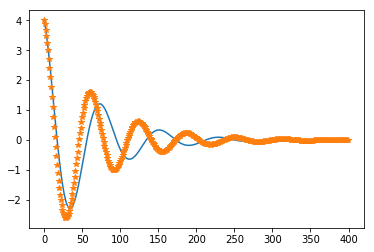

In [18]:
x_hat = [x0]
for i in range(len(x)):
        x_new = A*x_hat[-1]
        x_hat.append(x_new)
x_hat = np.hstack(x_hat)

plt.plot(x_hat[1,:].T)
plt.plot(dxdt_truth, '*')

# Now use the data driven estimate of A to estimate dxdt_hat with a Kalman smoother

In [19]:
params = [noise_parameters[1]**2, 0.7]

r, q = params

B = np.matrix([[0], [0], [0]])
C = np.matrix([[1, 0, 0]])
R = np.matrix([[r]])
Q = np.matrix([[1e-16, 0, 0], 
               [0, 1e-16, 0],
               [0,     0, q]])

x0 = np.matrix([[0], [4], [-13]])
P0 = np.matrix(1*np.eye(A.shape[0]))

In [20]:
x_hat, dxdt_hat = pynumdiff.kalman_smooth.known_dynamics(x, dt, [x0, P0, A, B, C, R, Q], 
                                                         options={'forwardbackward': True})

In [21]:
# first point is wrong
x_hat[0] = x0[0,0]
dxdt_hat[0] = x0[1,0]

(-5, 5)

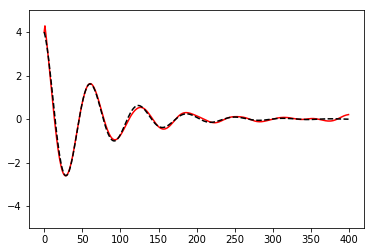

In [22]:
plt.plot(dxdt_hat, color='red')
plt.plot(dxdt_truth, '--', color='black')

plt.ylim(-5,5)


### RMS error in velocity estimate

This represents the best case RMS error in the velocity, assuming that the parameters happened to be chosen optimally. 

In [23]:
print(np.sqrt(np.mean((dxdt_hat - dxdt_truth)**2)))

0.08312561521588815
